# Project Title : Convert GAN implementation into IPython Notebook

# Goal : Create a GAN that generates fake celebrity images

# Source : 
https://github.com/tdeboissiere/DeepLearningImplementations/tree/master/GAN 

# Steps taken
1. Convert main model,training files
2. Create HDF5 dataset to be used for training using script provided
3. Trained network on 10000 images from CelebA dataset for 400 epochs
4. Added descriptions in code
5. Added all helper files in the main code : Data Utils is the only one used so far

# Other trials
1. Implemented BEGAN and converted into ipynb notebook and generated good looking images. But the code was too difficult to understand. Linked here
2. Try and implement PGGAN (Found a tensorflow implementation. But it uses CelebA-HQ dataset which is not available online, have to spend a lot of time just to get the correct data)

if you have helper files, then detailed instructions on how to use them. Maybe you can upload them somewhere and in your ipynb file, download them (try and keep the ipynb file as the only file, if possible)
detailed analysis of your results
your opinion on, what else you would have done if you had more time

comparison between your results and results from current state of art. 

# Brief about GAN Implementation and training
GANs are based on adversarial training.
Adversarial training is a basic technique to train generative models (so here primarily models that create new images).
In an adversarial training one model (G, Generator) generates things (e.g. images). Another model (D, discriminator) sees real things (e.g. real images) as well as fake things (e.g. images from G) and has to learn how to differentiate the two.

One of the main failure modes for GAN is for the generator to collapse to a parameter setting where
it always emits the same point. To avoid the same, we will also be using Mini-batch discrimination in our discriminator where we allow the discriminator to look at multiple data examples in combination, and perform minibatch discrimination. Any discriminator model that looks at multiple examples in combination, rather than in isolation, could potentially help avoid collapse of the generator.

![Generator model](https://cdn-images-1.medium.com/max/1600/1*mpTOQuSKqb-jsaGKqconvA.png)

**Training Process**

Generator G is a simple neural net (e.g. just one fully connected hidden layer). It takes a vector as input (e.g. 100 dimensions) and produces an image as output.

Discriminator D is a simple neural net (e.g. just one fully connected hidden layer). It takes an image as input and produces a quality rating as output (0-1, so sigmoid).

You need a training set of things to be generated, e.g. images of human faces.

Let the batch size be B.

**G is trained the following way:**
- Create B vectors of 100 random values each, e.g. sampled uniformly from [-1, +1]. (Number of values per components depends on the chosen input size of G.) 
- Feed forward the vectors through G to create new images. 
- Feed forward the images through D to create ratings.
- Use a cross entropy loss on these ratings. All of these (fake) images should be viewed as label=0 by D. If D gives them label=1, the error will be low (G did a good job).
- Perform a backward pass of the errors through D (without training D). That generates gradients/errors per image and pixel.
- Perform a backward pass of these errors through G to train G.

**D is trained the following way:**
- Create B/2 images using G (again, B/2 random vectors, feed forward through G).
- Chose B/2 images from the training set. Real images get label=1.
- Merge the fake and real images to one batch. Fake images get label=0.
- Feed forward the batch through D.
- Measure the error using cross entropy.
- Perform a backward pass with the error through D.

Train G for one batch, then D for one (or more) batches. Sometimes D can be too slow to catch up with G, then you need more iterations of D per batch of G.

In [1]:
!git clone https://github.com/siddharthalodha/DCGAN_KERAS.git
!cp -r DCGAN_KERAS/models .
!cp -r DCGAN_KERAS/figures .
!cp -r DCGAN_KERAS/utils .  

Cloning into 'DCGAN_KERAS'...
remote: Counting objects: 32, done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 32 (delta 9), reused 30 (delta 7), pack-reused 0
Unpacking objects: 100% (32/32), done.


# Download CelebA dataset from Google drive

This HDF5 Dataset has been generated manually from CelebA images. It contains over 2,00,000 images. We will only be using 10,000 images for our training.

In [2]:
#Code to download CelebA hdf5 dataset from google drive
!pip install PyDrive

from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileId = drive.CreateFile({'id': '1cUBPxqU-9Y6f_OAfPwdRmPg7ruZ2sfdk'})
print(fileId['title'])  # CelebA Dataset
fileId.GetContentFile('CelebA_64_data.h5')  # Save Drive file as a local file

CelebA_64_data.h5


# Import libraries

In [3]:
!pip install -q keras
import keras

!apt-get -qq install -y graphviz && pip install -q pydot

Using TensorFlow backend.


Selecting previously unselected package fontconfig.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../01-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5ubuntu0.1_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5ubuntu0.1) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6.0-3_amd64.deb ...
Unpa

Setting up libltdl7:amd64 (2.4.6-2) ...
Setting up libxcb-shm0:amd64 (1.12-1ubuntu1) ...
Setting up libxpm4:amd64 (1:3.5.12-1) ...
Setting up libxt6:amd64 (1:1.1.5-1) ...
Setting up libthai-data (0.1.26-3) ...
Setting up libcdt5 (2.38.0-16ubuntu2) ...
Setting up fontconfig (2.11.94-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcgraph6 (2.38.0-16ubuntu2) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libgvpr2 (2.38.0-16ubuntu2) ...
Setting up libgd3:amd64 (2.2.5-3) ...
Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
Setting up libthai0:amd64 (0.1.26-3) ...
Setting up libxmu6:amd64 (2:1.1.2-2) ...
Setting up libpango-1.0-0:amd64 (1.40.12-1) ...
Setting up libxaw7:amd64 (2:1.0.13-1) ...
Setting up libpangoft2-1.0-0:amd64 (1.40.12-1) ...
Setting up libpangocairo-1.0-0:amd64 (1.40.12-1) ...
Setting up libgvc6 (2.38.0-16ubuntu2) ...
Setting up graphviz (2.38.0-16ubuntu2) ...
Processing triggers for libc-bin (2.26-0ubuntu2

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import h5py

import pydot
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
import os
import sys
import time

import keras.backend as K

import tensorflow as tf

from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda, Reshape
from keras.layers.convolutional import Conv2D, Deconv2D, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization

from keras.utils import generic_utils
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from keras.utils.generic_utils import Progbar

from IPython.core.debugger import set_trace

sys.path.append("./utils") # Utils
import general_utils
#import data_utils #Being used for importing data,generating batches (CelebA Data is currently stored in an hdf5 file)
%matplotlib inline

#Check the Version of TensorFlow and Access to GPU 

In [3]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

Found GPU at: /device:GPU:0


# Define Hyperparameters

In [4]:
#Hyperparameters

#Specify backend to be used
backend="tensorflow"

#Specify dataset to be used, currently supported : mnist/celebA
dset="celebA"

#Generator model to be used : upsampling(For celebA)/deconv(For MNIST)
generator="upsampling"

#Model Name
model_name="CNN"

#Batch size to be used
batch_size=32

#Number of batches per epoch
n_batch_per_epoch=200

#Number of epochs
nb_epoch=400

#Epoch size => Used for progress bars (Progbar not being used in this code due to issue with iPython and KERAS)
epoch=10

#Number of classes
nb_classes=2

#Plotting during execution
do_plot=True 

#Batch normalization mode
bn_mode=2 

#Image dimensions
img_dim=64

#Flag to use label smoothing (Not making discriminator output as 1 even if it is a real image and not making it 0 when it's a fake image to smooth the labels)
label_smoothing="store_true"

#Flag to use label flipping (Flip labels for some images when training: real = fake, fake = real)
label_flipping=0

#Noise scale for initialization
noise_scale=0.5 

#Flag to enable mini batch discrimination  (Used to solve mode collapse problem - Was introducted in a new paper)
# Improved Techniques for Training GANs https://arxiv.org/abs/1606.03498
use_mbd="store_true"

#Image data format : Tensorflow = channels_last / Theano = channels_first
image_data_format = "channels_last"

#Data Utils
Contains functions to
- Load images from CelebA,MNIST dataset
- Generate batches for discriminator and generator functions

In [5]:
def normalization(X):

    return X / 127.5 - 1


def inverse_normalization(X):

    return (X + 1.) / 2.


def load_mnist(image_data_format):

    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    if image_data_format == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
        X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    else:
        X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
        X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train = normalization(X_train)
    X_test = normalization(X_test)

    nb_classes = len(np.unique(np.hstack((y_train, y_test))))

    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

    return X_train, Y_train, X_test, Y_test

  
def load_celebA(img_dim, image_data_format):

    with h5py.File("./CelebA_%s_data.h5" % img_dim, "r") as hf:

        X_real_train = hf["data"][:10000].astype(np.float32)
        X_real_train = normalization(X_real_train)

        if image_data_format == "channels_last":
            X_real_train = X_real_train.transpose(0, 2, 3, 1)

        return X_real_train


def gen_batch(X, batch_size):

    while True:
        idx = np.random.choice(X.shape[0], batch_size, replace=False)
        yield X[idx]


def sample_noise(noise_scale, batch_size, noise_dim):

    return np.random.normal(scale=noise_scale, size=(batch_size, noise_dim[0]))


#Get batches for discriminator. Alternate between real and fake images. The batch for real images has 1 as output and batch for generator images has 0 as output.
#Label flipping makes some expected output of real images to 0 and some fake images to 1 to train the discriminator better and not overfit on distribution of training images
def get_disc_batch(X_real_batch, generator_model, batch_counter, batch_size, noise_dim,
                   noise_scale=0.5, label_smoothing=False, label_flipping=0):

    # Create X_disc: alternatively only generated or real images
    if batch_counter % 2 == 0:
        # Pass noise to the generator
        noise_input = sample_noise(noise_scale, batch_size, noise_dim)
        # Produce an output
        X_disc = generator_model.predict(noise_input)
        y_disc = np.zeros((X_disc.shape[0], 2), dtype=np.uint8)
        y_disc[:, 0] = 1

        if label_flipping > 0:
            p = np.random.binomial(1, label_flipping)
            if p > 0:
                y_disc[:, [0, 1]] = y_disc[:, [1, 0]]

    else:
        X_disc = X_real_batch
        y_disc = np.zeros((X_disc.shape[0], 2), dtype=np.uint8)
        if label_smoothing:
            y_disc[:, 1] = np.random.uniform(low=0.9, high=1, size=y_disc.shape[0])
        else:
            y_disc[:, 1] = 1

        if label_flipping > 0:
            p = np.random.binomial(1, label_flipping)
            if p > 0:
                y_disc[:, [0, 1]] = y_disc[:, [1, 0]]

    return X_disc, y_disc


def get_disc_batch_mixed(X_real_batch, generator_model, batch_counter, batch_size, noise_dim, noise_scale=0.5):

    # Pass noise to the generator
    noise_input = sample_noise(noise_scale, batch_size / 2, noise_dim)
    # Produce an output
    X_disc_noise = generator_model.predict(noise_input)
    y_disc_noise = np.zeros((X_disc_noise.shape[0], 2), dtype=np.uint8)
    y_disc_noise[:, 0] = 1

    X_disc = X_real_batch[:batch_size / 2]
    y_disc = np.zeros((X_disc.shape[0], 2), dtype=np.uint8)
    y_disc[:, 1] = 1

    X_disc = np.concatenate((X_disc, X_disc_noise))
    y_disc = np.concatenate((y_disc, y_disc_noise))

    return X_disc, y_disc


def get_gen_batch(batch_size, noise_dim, noise_scale=0.5):

    X_gen = sample_noise(noise_scale, batch_size, noise_dim)
    y_gen = np.zeros((X_gen.shape[0], 2), dtype=np.uint8)
    y_gen[:, 1] = 1

    return X_gen, y_gen


def plot_generated_batch(X_real, generator_model, batch_size, noise_dim, image_data_format, noise_scale=0.5):

    # Generate images
    X_gen = sample_noise(noise_scale, batch_size, noise_dim)
    X_gen = generator_model.predict(X_gen)

    X_real = inverse_normalization(X_real)
    X_gen = inverse_normalization(X_gen)

    Xg = X_gen[:8]
    Xr = X_real[:8]

    if image_data_format == "channels_last":
        X = np.concatenate((Xg, Xr), axis=0)
        list_rows = []
        for i in range(int(X.shape[0] / 4)):
            Xr = np.concatenate([X[k] for k in range(4 * i, 4 * (i + 1))], axis=1)
            list_rows.append(Xr)

        Xr = np.concatenate(list_rows, axis=0)

    if image_data_format == "channels_first":
        X = np.concatenate((Xg, Xr), axis=0)
        list_rows = []
        for i in range(int(X.shape[0] / 4)):
            Xr = np.concatenate([X[k] for k in range(4 * i, 4 * (i + 1))], axis=2)
            list_rows.append(Xr)

        Xr = np.concatenate(list_rows, axis=1)
        Xr = Xr.transpose(1,2,0)

    if Xr.shape[-1] == 1:
        plt.imshow(Xr[:, :, 0], cmap="gray")
    else:
        plt.imshow(Xr)
    plt.savefig("./figures/current_batch.png")
    plt.clf()
    plt.close()
    
    
#Display generated image
def show_image():
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from scipy import ndimage, misc
    
    img=mpimg.imread('./figures/current_batch.png')
    imgplot = plt.imshow(img)
    plt.show()
    
    return

#  Define generator model#1 : Upsampling

Preferable for CelebA dataset
---
A 100 dimensional uniform distribution Z is projected to a small spatial extent convolutional representation with many feature maps. The first layer of the GAN, which takes a uniform noise distribution Z as input, could be called fully connected as it is just a matrix multiplication, but the result is reshaped into a 4-dimensional tensor and used as the start of the convolution stack. After applying the same, we apply Batchnormalization and RELU activation on the same.

Batchnormalization helps in stabilizing learning by normalizing the input to each unit to have zero mean and unit variance. This helps deal with training problems that arise due to poor initialization and helps gradient flow in deeper models. This proved critical in getting deep generators to begin learning, preventing the generator from collapsing all samples to a single point which is a common failure mode observed in GANs. Directly applying batchnorm to all layers however, resulted in sample oscillation and model instability. This was avoided by not applying batchnorm to the generator output layer and the discriminator input layer.

RELU  is used in the generator with the exception of the output layer which uses the Tanh function. It is  observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. 

Post that, we add upsampling convolution blocks on the same.  

For MNIST, as the dataset is not very complex, we prefer 2 upsampling blocks. Also, we start at 16x16. We scale to 32x32 first and then 64x64 in the second round.
For CelebA, as the dataset is more complex and more differentiable features are to be generated, we prefer 4 upsampling blocks. We start with 4x4 image and scale to 8x8, 16x16,32x32 and 64x64.

During the upsampling process, we first apply a upsampling layer to increase the image dimensions by 2x by repeating the existing data and then we apply 3x3 convolution two times where we reduce filter by a multiple of 2 in every iteration. We also apply Batch normalization and RELU activation for the reasons already listed above.

In [6]:
def generator_upsampling(noise_dim, img_dim, bn_mode, model_name="generator_upsampling", dset="celebA"):
    """
    Generator model of the DCGAN
    args : img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """

    s = img_dim[1]
    f = 512

    if dset == "mnist":
        start_dim = int(s / 4)
        nb_upconv = 2
    else:
        start_dim = int(s / 16)
        nb_upconv = 4

    if K.image_data_format() == "channels_first":
        bn_axis = 1
        reshape_shape = (f, start_dim, start_dim)
        output_channels = img_dim[0]
    else:
        reshape_shape = (start_dim, start_dim, f)
        bn_axis = -1
        output_channels = img_dim[-1]

    gen_input = Input(shape=noise_dim, name="generator_input")

    x = Dense(f * start_dim * start_dim, input_dim=noise_dim)(gen_input)
    x = Reshape(reshape_shape)(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    # Upscaling blocks
    for i in range(nb_upconv):
        x = UpSampling2D(size=(2, 2))(x)
        nb_filters = int(f / (2 ** (i + 1)))
        x = Conv2D(nb_filters, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=1)(x)
        x = Activation("relu")(x)
        x = Conv2D(nb_filters, (3, 3), padding="same")(x)
        x = Activation("relu")(x)

    x = Conv2D(output_channels, (3, 3), name="gen_Conv2D_final", padding="same", activation='tanh')(x)

    generator_model = Model(inputs=[gen_input], outputs=[x], name=model_name)

    return generator_model

# Define generator model#2 : Deconvolution

Preferable for MNIST dataset
---
Instead of applying multiple 3x3 convolutions, we used transposed convolutions or Deconvolution with stride of 2 to get the same result as we got in the above process. This has been bettered by the above upsampling implementation of the generator as using strides result in checkerboard issue. This doesn't affect the MNIST dataset but is very apparent in faces

In [7]:
def generator_deconv(noise_dim, img_dim, bn_mode, batch_size, model_name="generator_deconv", dset="mnist"):
    """
    Generator model of the DCGAN
    args : nb_classes (int) number of classes
           img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """

    assert K.backend() == "tensorflow", "Deconv not implemented with theano"

    s = img_dim[1]
    f = 512

    if dset == "mnist":
        start_dim = int(s / 4)
        nb_upconv = 2
    else:
        start_dim = int(s / 16)
        nb_upconv = 4

    reshape_shape = (start_dim, start_dim, f)
    bn_axis = -1
    output_channels = img_dim[-1]

    gen_input = Input(shape=noise_dim, name="generator_input")

    x = Dense(f * start_dim * start_dim, input_dim=noise_dim)(gen_input)
    x = Reshape(reshape_shape)(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    # Transposed conv blocks
    for i in range(nb_upconv - 1):
        nb_filters = int(f / (2 ** (i + 1)))
        s = start_dim * (2 ** (i + 1))
        o_shape = (batch_size, s, s, nb_filters)
        x = Deconv2D(nb_filters, (3, 3), output_shape=o_shape, strides=(2, 2), padding="same")(x)
        x = BatchNormalization(axis=-1)(x)
        x = Activation("relu")(x)

    # Last block
    s = start_dim * (2 ** (nb_upconv))
    o_shape = (batch_size, s, s, output_channels)
    x = Deconv2D(output_channels, (3, 3), output_shape=o_shape, strides=(2, 2), padding="same")(x)
    x = Activation("tanh")(x)

    generator_model = Model(inputs=[gen_input], outputs=[x], name=model_name)

    return generator_model

# Define discriminator model

Discriminator D is a simple neural net (e.g. just one fully connected hidden layer). It takes an image as input and produces a quality rating as output (0-1, so sigmoid). It is p

To train the discriminator, we use 3x3 convolutions with strides of 2. We increase the filter size by a multiple of 2 in each pass. For MNIST, we only apply convolutions twice. For CelebA, we prefer to apply convolutions 4 times. Each time, the convolutions are accompanied with batch normalization and leaky relu with 0.2 leakage coefficient. Within the discriminator leaky rectified activation works better, especially for higher resolution modeling.

For the discriminator, the last convolution layer is flattened and then fed into a single sigmoid output.

We also use MBD (Mini-batch discrimination) to allow the discriminator to look at multiple data examples in combination to avoid the problem of mode collapse. 

In [8]:
def DCGAN_discriminator(noise_dim, img_dim, bn_mode, model_name="DCGAN_discriminator", dset="celebA", use_mbd=False):
    """
    Discriminator model of the DCGAN
    args : img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """
    #Image data format : channels_first for theano backend and channels_last for tensorflow backend
    if K.image_data_format() == "channels_first":
        bn_axis = 1
    else:
        bn_axis = -1

    disc_input = Input(shape=img_dim, name="discriminator_input")

    if dset == "mnist":
        list_f = [128]

    else:
        list_f = [64, 128, 256]

    # First conv
    x = Conv2D(32, (3, 3), strides=(2, 2), name="disc_Conv2D_1", padding="same")(disc_input)
    x = BatchNormalization(axis=bn_axis)(x)
    x = LeakyReLU(0.2)(x)

    # Next convs
    for i, f in enumerate(list_f):
        name = "disc_Conv2D_%s" % (i + 2)
        x = Conv2D(f, (3, 3), strides=(2, 2), name=name, padding="same")(x)
        x = BatchNormalization(axis=bn_axis)(x)
        x = LeakyReLU(0.2)(x)

    x = Flatten()(x)

    def minb_disc(x):
        diffs = K.expand_dims(x, 3) - K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), 2)
        x = K.sum(K.exp(-abs_diffs), 2)

        return x

    def lambda_output(input_shape):
        return input_shape[:2]

    num_kernels = 100
    dim_per_kernel = 5

    M = Dense(num_kernels * dim_per_kernel, use_bias=False, activation=None)
    MBD = Lambda(minb_disc, output_shape=lambda_output)

    if use_mbd:
        x_mbd = M(x)
        x_mbd = Reshape((num_kernels, dim_per_kernel))(x_mbd)
        x_mbd = MBD(x_mbd)
        x = Concatenate(axis=bn_axis)([x, x_mbd])

    x = Dense(2, activation='softmax', name="disc_dense_2")(x)

    discriminator_model = Model(inputs=[disc_input], outputs=[x], name=model_name)

    return discriminator_model

# Prepare DCGAN model

DCGAN comprises of both generator and discriminator where both are pitted against each other. Alternate models are frozen while training DCGAN. When Discriminator is being trained, generator is frozen and vice versa.

In [9]:
def DCGAN(generator, discriminator_model, noise_dim, img_dim):

    noise_input = Input(shape=noise_dim, name="noise_input")

    generated_image = generator(noise_input)
    DCGAN_output = discriminator_model(generated_image)

    DCGAN = Model(inputs=[noise_input],
                  outputs=[DCGAN_output],
                  name="DCGAN")
    return DCGAN

# Choose models

Implement loader to load specific models : 
1. Generators : Upsampling, Deconvolution
2. Discriminator


In [10]:
def load(model_name, noise_dim, img_dim, bn_mode, batch_size, dset="mnist", use_mbd=False):

    if model_name == "generator_upsampling":
        model = generator_upsampling(noise_dim, img_dim, bn_mode, model_name=model_name, dset=dset)
        model.summary()
        plot_model(model, to_file='./figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model
    if model_name == "generator_deconv":
        model = generator_deconv(noise_dim, img_dim, bn_mode, batch_size, model_name=model_name, dset=dset)
        model.summary()
        plot_model(model, to_file='./figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model
    if model_name == "DCGAN_discriminator":
        model = DCGAN_discriminator(noise_dim, img_dim, bn_mode, model_name=model_name, dset=dset, use_mbd=use_mbd)
        model.summary()
        plot_model(model, to_file='./figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model

# Train the network
- We use a Generator G (simple neural net)
- G takes a random vector as input (e.g. vector of 100 random values between -1 and +1).
- G creates an image as output.
- We use a Discriminator D (simple neural net)
- D takes an image as input (can be real or generated by G).
- D creates a rating as output (quality, i.e. a value between 0 and 1, where 0 means "probably fake").
- Outputs from G are fed into D. 
- The result can then be backpropagated through D and then G. G is trained to maximize log(D(image)), so to create a high value of D(image).
- D is trained to produce only 1s for images from G.
- Both are trained simultaneously, i.e. one batch for G, then one batch for D, then one batch for G and so on.
- D can also be trained multiple times in a row. That allows it to catch up with G.





In [14]:
def train_GAN(batch_size,n_batch_per_epoch,nb_epoch,generator,model_name,image_data_format,img_dim,bn_mode,label_smoothing,label_flipping,noise_scale,dset,use_mbd,epoch_size):
    # Setup environment (logging directory etc)
    general_utils.setup_logging(model_name)

    # Load and rescale data
    if dset == "celebA":
        X_real_train = load_celebA(img_dim, image_data_format)
    if dset == "mnist":
        X_real_train, _, _, _ = load_mnist(image_data_format)
    img_dim = X_real_train.shape[-3:]
    noise_dim = (100,)
    
    try:

        # Create optimizers
        opt_dcgan = Adam(lr=2E-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
        opt_discriminator = SGD(lr=1E-3, momentum=0.9, nesterov=True)

        # Load generator model
        generator_model = load("generator_%s" % generator,
                                      noise_dim,
                                      img_dim,
                                      bn_mode,
                                      batch_size,
                                      dset=dset,
                                      use_mbd=use_mbd)
        
        # Load discriminator model
        discriminator_model = load("DCGAN_discriminator",
                                          noise_dim,
                                          img_dim,
                                          bn_mode,
                                          batch_size,
                                          dset=dset,
                                          use_mbd=use_mbd)

        generator_model.compile(loss='mse', optimizer=opt_discriminator)
        discriminator_model.trainable = False
        DCGAN_model = DCGAN(generator_model,
                                   discriminator_model,
                                   noise_dim,
                                   img_dim)
        
        loss = ['binary_crossentropy']
        loss_weights = [1]
        DCGAN_model.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_dcgan) #Compile DCGAN model with optimizer as adam

        discriminator_model.trainable = True
        discriminator_model.compile(loss='binary_crossentropy', optimizer=opt_discriminator)

        #Initiliaze generator and discriminator loss
        gen_loss = 100
        disc_loss = 100

        # Start training for epochs=nb_epoch 
        print("Start training")
        for e in range(nb_epoch):
            #Initialize progbar and batch counter
            #progbar = Progbar(epoch_size) #Progbar has some issue with keras/ipynb notebooks
            batch_counter = 1
            start = time.time()
            for X_real_batch in gen_batch(X_real_train, batch_size):

                # Create a batch to feed the discriminator model
                X_disc, y_disc = get_disc_batch(X_real_batch,
                                                           generator_model,
                                                           batch_counter,
                                                           batch_size,
                                                           noise_dim,
                                                           noise_scale=noise_scale,
                                                           label_smoothing=label_smoothing,
                                                           label_flipping=label_flipping)

                # Update the discriminator
                #train_on_batch is used for training instead of the traditional model.fit because we need to update existing trained model on new batch.
                #train_on_batch is for updating a pre-trained model on a single new batch of samples
                disc_loss = discriminator_model.train_on_batch(X_disc, y_disc)

                # Create a batch to feed the generator model
                X_gen, y_gen = get_gen_batch(batch_size, noise_dim, noise_scale=noise_scale)

                # Freeze the discriminator
                discriminator_model.trainable = False
                gen_loss = DCGAN_model.train_on_batch(X_gen, y_gen)
                # Unfreeze the discriminator
                discriminator_model.trainable = True

                batch_counter += 1
                #progbar.add(batch_size, values=[("D logloss", disc_loss),
                #                                ("G logloss", gen_loss)])

                 #Save images for visualization
                if batch_counter % 100 == 0:
                    plot_generated_batch(X_real_batch, generator_model,
                                                    batch_size, noise_dim, image_data_format)
                    
                if batch_counter >= n_batch_per_epoch:
                    break

            print("")
            print('Epoch %s/%s, Time: %s, Discriminator loss:%s,Generator loss:%s' % (e + 1, nb_epoch, time.time() - start,disc_loss,gen_loss))

            #Save weights for generator,discriminator and DCGAN 
            if e % 5 == 0:
                print(e)
                show_image() #Display generated image after every 5 epochs

                gen_weights_path = os.path.join('./models/%s/gen_weights_epoch%s.h5' % (model_name, e))
                generator_model.save_weights(gen_weights_path, overwrite=True)

                disc_weights_path = os.path.join('./models/%s/disc_weights_epoch%s.h5' % (model_name, e))
                discriminator_model.save_weights(disc_weights_path, overwrite=True)

                DCGAN_weights_path = os.path.join('./models/%s/DCGAN_weights_epoch%s.h5' % (model_name, e))
                DCGAN_model.save_weights(DCGAN_weights_path, overwrite=True)
    except Exception as e:
            print(e)

# Setup environment and initialize the training process

** We save the weights and show the generated images after every 5 epochs. **

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_10 (Activation)   (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 256)         1179904   
__________

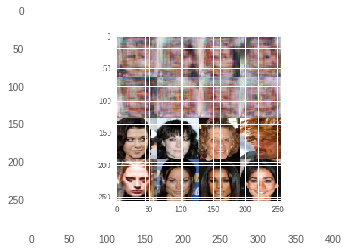


Epoch 2/400, Time: 25.324665069580078, Discriminator loss:1.055459,Generator loss:1.8632524

Epoch 3/400, Time: 25.35697627067566, Discriminator loss:0.88549477,Generator loss:2.9975781

Epoch 4/400, Time: 25.36338186264038, Discriminator loss:0.9893176,Generator loss:1.6150523

Epoch 5/400, Time: 25.343912363052368, Discriminator loss:0.9908699,Generator loss:1.8319387

Epoch 6/400, Time: 25.328200578689575, Discriminator loss:0.9652874,Generator loss:1.4741617
5


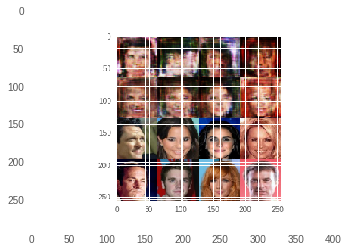


Epoch 7/400, Time: 25.333548069000244, Discriminator loss:1.0489926,Generator loss:1.2622007

Epoch 8/400, Time: 25.315542459487915, Discriminator loss:0.949273,Generator loss:1.8488741

Epoch 9/400, Time: 25.355475902557373, Discriminator loss:1.2428848,Generator loss:1.7010617

Epoch 10/400, Time: 25.318026065826416, Discriminator loss:1.0460284,Generator loss:2.3795044

Epoch 11/400, Time: 25.314974546432495, Discriminator loss:0.86336654,Generator loss:1.6591529
10


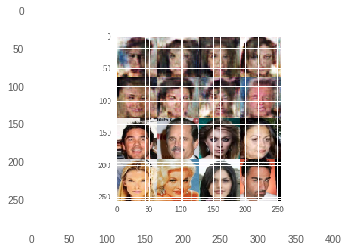


Epoch 12/400, Time: 25.369730472564697, Discriminator loss:1.004776,Generator loss:1.9410076

Epoch 13/400, Time: 25.314074993133545, Discriminator loss:1.1813123,Generator loss:1.5840287

Epoch 14/400, Time: 25.320303916931152, Discriminator loss:0.9541406,Generator loss:1.776402

Epoch 15/400, Time: 25.318533658981323, Discriminator loss:1.0601215,Generator loss:1.2508943

Epoch 16/400, Time: 25.318882942199707, Discriminator loss:1.0102913,Generator loss:1.9570707
15


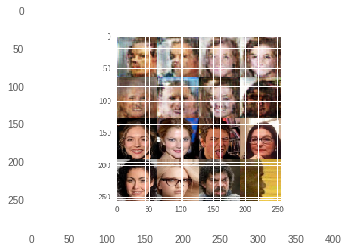


Epoch 17/400, Time: 25.340751886367798, Discriminator loss:0.88232815,Generator loss:1.4344308

Epoch 18/400, Time: 25.365329265594482, Discriminator loss:1.1911325,Generator loss:1.1031381

Epoch 19/400, Time: 25.35504984855652, Discriminator loss:1.1627625,Generator loss:1.7270402

Epoch 20/400, Time: 25.31897807121277, Discriminator loss:0.770635,Generator loss:2.1135113

Epoch 21/400, Time: 25.31881618499756, Discriminator loss:1.0528731,Generator loss:1.8043242
20


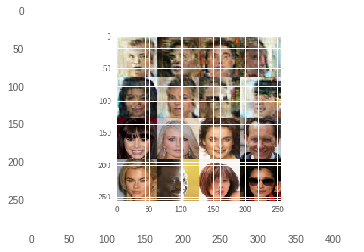


Epoch 22/400, Time: 25.31196093559265, Discriminator loss:0.97689474,Generator loss:1.7377207

Epoch 23/400, Time: 25.30980086326599, Discriminator loss:0.8676861,Generator loss:1.9199345

Epoch 24/400, Time: 25.3729190826416, Discriminator loss:0.91665757,Generator loss:1.5888506

Epoch 25/400, Time: 25.339178800582886, Discriminator loss:1.0236161,Generator loss:1.2720678

Epoch 26/400, Time: 25.371589183807373, Discriminator loss:1.1474042,Generator loss:1.8169125
25


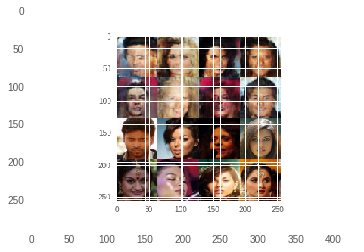


Epoch 27/400, Time: 25.34469485282898, Discriminator loss:1.046668,Generator loss:1.8475356

Epoch 28/400, Time: 25.329946517944336, Discriminator loss:0.96440774,Generator loss:1.408416

Epoch 29/400, Time: 25.344014644622803, Discriminator loss:0.82004416,Generator loss:1.5643308

Epoch 30/400, Time: 25.305440187454224, Discriminator loss:1.2259703,Generator loss:1.8392007

Epoch 31/400, Time: 25.334349393844604, Discriminator loss:1.1279366,Generator loss:1.8067644
30


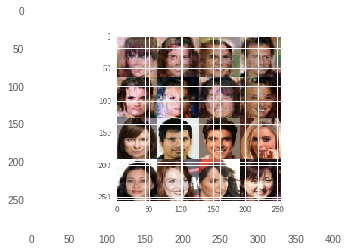


Epoch 32/400, Time: 25.354466438293457, Discriminator loss:0.79610157,Generator loss:2.6045706

Epoch 33/400, Time: 25.32514500617981, Discriminator loss:0.9424401,Generator loss:1.735777

Epoch 34/400, Time: 25.313737392425537, Discriminator loss:0.86543554,Generator loss:1.7933769

Epoch 35/400, Time: 25.357561826705933, Discriminator loss:0.8115492,Generator loss:2.338196

Epoch 36/400, Time: 25.300450325012207, Discriminator loss:0.9127836,Generator loss:1.7416313
35


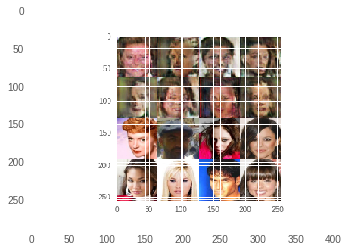


Epoch 37/400, Time: 25.33687925338745, Discriminator loss:1.1723067,Generator loss:2.1215503

Epoch 38/400, Time: 25.33952784538269, Discriminator loss:0.8378131,Generator loss:2.2321794

Epoch 39/400, Time: 25.287757396697998, Discriminator loss:0.93069863,Generator loss:1.7013108

Epoch 40/400, Time: 25.35677671432495, Discriminator loss:0.8903909,Generator loss:1.8743284

Epoch 41/400, Time: 25.324044466018677, Discriminator loss:0.8897161,Generator loss:1.858315
40


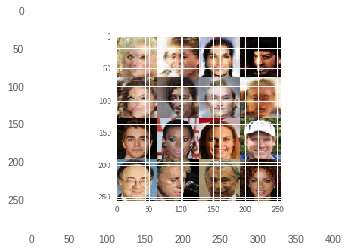


Epoch 42/400, Time: 25.343814611434937, Discriminator loss:0.8786295,Generator loss:1.9896095

Epoch 43/400, Time: 25.333553791046143, Discriminator loss:0.9101558,Generator loss:1.407416

Epoch 44/400, Time: 25.34043836593628, Discriminator loss:0.86194646,Generator loss:1.6286153

Epoch 45/400, Time: 25.323224544525146, Discriminator loss:0.89724016,Generator loss:2.4773493

Epoch 46/400, Time: 25.344531774520874, Discriminator loss:0.83685267,Generator loss:2.3246388
45


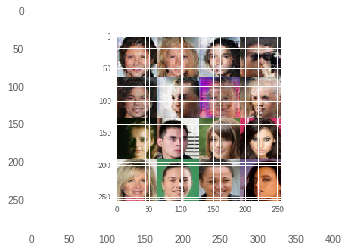


Epoch 47/400, Time: 25.366734266281128, Discriminator loss:1.1482115,Generator loss:2.0482807

Epoch 48/400, Time: 25.262063026428223, Discriminator loss:1.0617131,Generator loss:2.0281281

Epoch 49/400, Time: 25.304157257080078, Discriminator loss:0.8594556,Generator loss:2.5437841

Epoch 50/400, Time: 25.286981344223022, Discriminator loss:0.8886286,Generator loss:1.9311897

Epoch 51/400, Time: 25.31631875038147, Discriminator loss:0.8242115,Generator loss:1.8690414
50


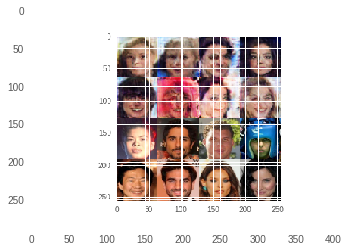


Epoch 52/400, Time: 25.318461894989014, Discriminator loss:1.2032299,Generator loss:1.9076024

Epoch 53/400, Time: 25.3597092628479, Discriminator loss:0.8770033,Generator loss:2.1270838

Epoch 54/400, Time: 25.311067819595337, Discriminator loss:0.80980575,Generator loss:2.8842974

Epoch 55/400, Time: 25.302159547805786, Discriminator loss:0.85238975,Generator loss:2.268891

Epoch 56/400, Time: 25.354231357574463, Discriminator loss:0.8806674,Generator loss:2.2320693
55


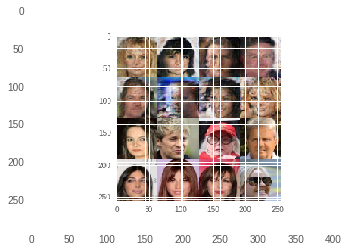


Epoch 57/400, Time: 25.35548758506775, Discriminator loss:0.81614995,Generator loss:2.1862016

Epoch 58/400, Time: 25.30050778388977, Discriminator loss:1.0822144,Generator loss:1.3660288

Epoch 59/400, Time: 25.30462956428528, Discriminator loss:0.9567324,Generator loss:2.0805883

Epoch 60/400, Time: 25.35136318206787, Discriminator loss:0.8738719,Generator loss:2.25413

Epoch 61/400, Time: 25.34637951850891, Discriminator loss:0.84340554,Generator loss:2.1298242
60


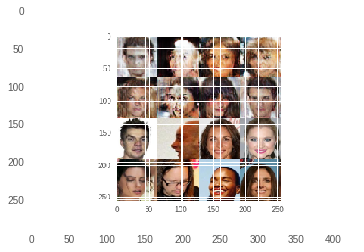


Epoch 62/400, Time: 25.295846223831177, Discriminator loss:0.8832402,Generator loss:2.2602441

Epoch 63/400, Time: 25.31993532180786, Discriminator loss:0.8095846,Generator loss:2.879469

Epoch 64/400, Time: 25.306164503097534, Discriminator loss:0.83462644,Generator loss:2.628429

Epoch 65/400, Time: 25.35266900062561, Discriminator loss:0.8601434,Generator loss:1.7335606

Epoch 66/400, Time: 25.32016611099243, Discriminator loss:0.8920405,Generator loss:2.0079567
65


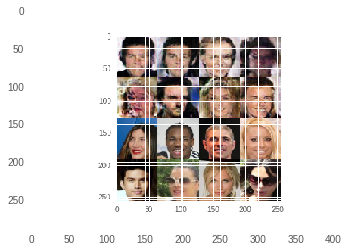


Epoch 67/400, Time: 25.359342098236084, Discriminator loss:0.81300044,Generator loss:2.150888

Epoch 68/400, Time: 25.348658561706543, Discriminator loss:0.8085581,Generator loss:2.5057607

Epoch 69/400, Time: 25.3290274143219, Discriminator loss:1.0594606,Generator loss:2.4871702

Epoch 70/400, Time: 25.306524753570557, Discriminator loss:0.77725905,Generator loss:3.223485

Epoch 71/400, Time: 25.314265489578247, Discriminator loss:0.8982943,Generator loss:2.4817758
70


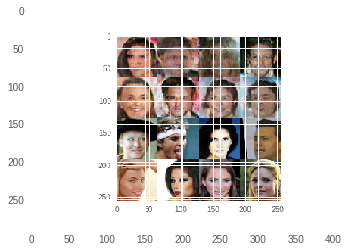


Epoch 72/400, Time: 25.307807207107544, Discriminator loss:0.8906407,Generator loss:1.8938313

Epoch 73/400, Time: 25.3135507106781, Discriminator loss:0.90025574,Generator loss:1.5407256

Epoch 74/400, Time: 25.34018874168396, Discriminator loss:0.77386963,Generator loss:2.4450536

Epoch 75/400, Time: 25.331433296203613, Discriminator loss:0.7645298,Generator loss:2.7184532

Epoch 76/400, Time: 25.326249837875366, Discriminator loss:0.7574295,Generator loss:3.349641
75


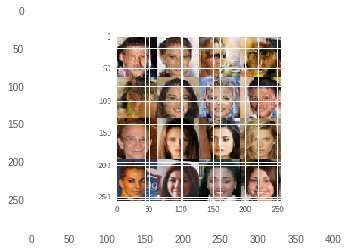


Epoch 77/400, Time: 25.35952877998352, Discriminator loss:0.78899443,Generator loss:2.4097219

Epoch 78/400, Time: 25.300004482269287, Discriminator loss:0.80708396,Generator loss:2.3810086

Epoch 79/400, Time: 25.339250087738037, Discriminator loss:0.7806506,Generator loss:2.1783192

Epoch 80/400, Time: 25.31400156021118, Discriminator loss:0.80735284,Generator loss:2.2872162

Epoch 81/400, Time: 25.352728605270386, Discriminator loss:0.8505102,Generator loss:1.8276539
80


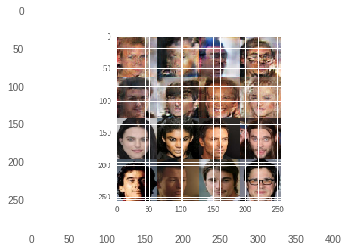


Epoch 82/400, Time: 25.31222414970398, Discriminator loss:0.797812,Generator loss:2.6401625

Epoch 83/400, Time: 25.333784580230713, Discriminator loss:0.7963563,Generator loss:2.3627398

Epoch 84/400, Time: 25.335662603378296, Discriminator loss:0.85937357,Generator loss:2.9554968

Epoch 85/400, Time: 25.31226897239685, Discriminator loss:0.80124533,Generator loss:3.365271

Epoch 86/400, Time: 25.267756938934326, Discriminator loss:0.772998,Generator loss:3.099904
85


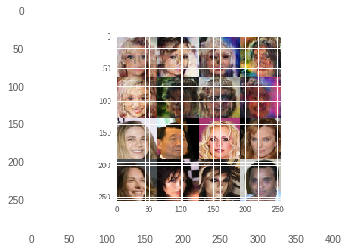


Epoch 87/400, Time: 25.33238410949707, Discriminator loss:0.82789993,Generator loss:3.1103692

Epoch 88/400, Time: 25.242849349975586, Discriminator loss:0.8102927,Generator loss:3.0597296

Epoch 89/400, Time: 25.247644662857056, Discriminator loss:0.9955677,Generator loss:2.0093281

Epoch 90/400, Time: 25.292470932006836, Discriminator loss:0.9142871,Generator loss:3.0774975

Epoch 91/400, Time: 25.26922583580017, Discriminator loss:0.79952663,Generator loss:2.829897
90


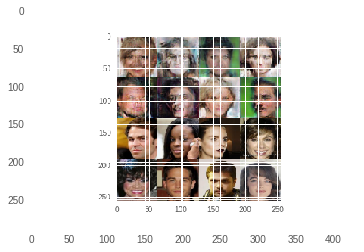


Epoch 92/400, Time: 25.24732732772827, Discriminator loss:0.7802708,Generator loss:2.9414434

Epoch 93/400, Time: 25.23197841644287, Discriminator loss:0.79499745,Generator loss:3.0017571

Epoch 94/400, Time: 25.239988088607788, Discriminator loss:0.79188144,Generator loss:3.496889

Epoch 95/400, Time: 25.262796878814697, Discriminator loss:0.838364,Generator loss:2.155067

Epoch 96/400, Time: 25.256029844284058, Discriminator loss:0.8726802,Generator loss:2.7502933
95


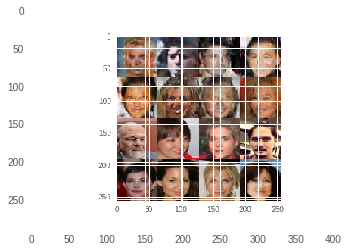


Epoch 97/400, Time: 25.341039180755615, Discriminator loss:0.9397794,Generator loss:2.3321285

Epoch 98/400, Time: 25.273762941360474, Discriminator loss:0.80129015,Generator loss:2.3938496

Epoch 99/400, Time: 25.31042742729187, Discriminator loss:0.8670713,Generator loss:2.859014

Epoch 100/400, Time: 25.37439727783203, Discriminator loss:0.8703406,Generator loss:2.5882592

Epoch 101/400, Time: 25.40980577468872, Discriminator loss:0.7929319,Generator loss:3.0059457
100


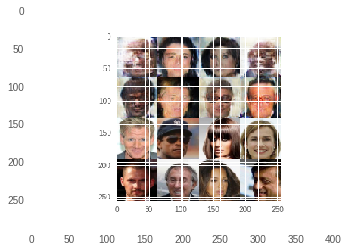


Epoch 102/400, Time: 25.602969884872437, Discriminator loss:0.8850781,Generator loss:2.7106519

Epoch 103/400, Time: 25.255996704101562, Discriminator loss:0.83301115,Generator loss:1.8212059

Epoch 104/400, Time: 25.272690534591675, Discriminator loss:0.8700131,Generator loss:2.3203318

Epoch 105/400, Time: 25.26691174507141, Discriminator loss:0.86495876,Generator loss:2.4682028

Epoch 106/400, Time: 25.283145904541016, Discriminator loss:0.8732528,Generator loss:3.143558
105


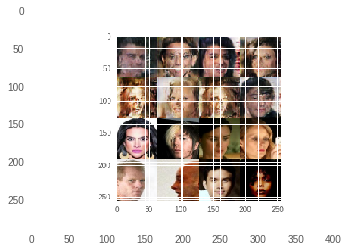


Epoch 107/400, Time: 25.32806086540222, Discriminator loss:0.8003022,Generator loss:2.1994352

Epoch 108/400, Time: 25.292320013046265, Discriminator loss:0.7932162,Generator loss:2.9360173

Epoch 109/400, Time: 25.266799211502075, Discriminator loss:0.8120456,Generator loss:2.9754262

Epoch 110/400, Time: 25.321127891540527, Discriminator loss:0.8697182,Generator loss:2.567707

Epoch 111/400, Time: 25.32225775718689, Discriminator loss:0.80913275,Generator loss:2.9817247
110


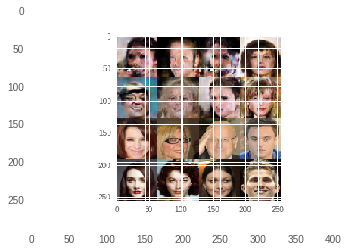


Epoch 112/400, Time: 25.327395915985107, Discriminator loss:0.8936635,Generator loss:2.398242

Epoch 113/400, Time: 25.28060483932495, Discriminator loss:0.7894165,Generator loss:2.6343868

Epoch 114/400, Time: 25.307008981704712, Discriminator loss:0.8570819,Generator loss:2.4439049

Epoch 115/400, Time: 25.273760557174683, Discriminator loss:0.8743577,Generator loss:2.9095678

Epoch 116/400, Time: 25.282004833221436, Discriminator loss:0.9498304,Generator loss:2.9042182
115


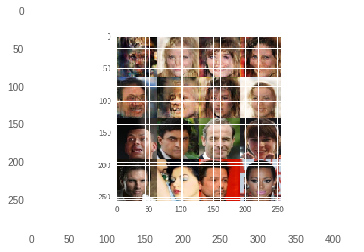


Epoch 117/400, Time: 25.314523220062256, Discriminator loss:0.8553752,Generator loss:2.7890801

Epoch 118/400, Time: 25.332919597625732, Discriminator loss:0.75623846,Generator loss:2.6616063

Epoch 119/400, Time: 25.28240156173706, Discriminator loss:0.80424464,Generator loss:2.879799

Epoch 120/400, Time: 25.231268644332886, Discriminator loss:0.8086518,Generator loss:2.67664

Epoch 121/400, Time: 25.26624608039856, Discriminator loss:0.7397014,Generator loss:2.7713118
120


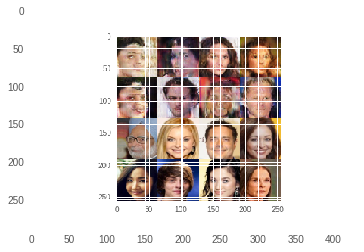


Epoch 122/400, Time: 25.30152702331543, Discriminator loss:0.77267385,Generator loss:2.8288383

Epoch 123/400, Time: 25.28868055343628, Discriminator loss:0.75450194,Generator loss:2.6159606

Epoch 124/400, Time: 25.30734920501709, Discriminator loss:0.8228165,Generator loss:2.8010616

Epoch 125/400, Time: 25.250291347503662, Discriminator loss:0.7923483,Generator loss:2.8669422

Epoch 126/400, Time: 25.225478649139404, Discriminator loss:0.81970465,Generator loss:3.623074
125


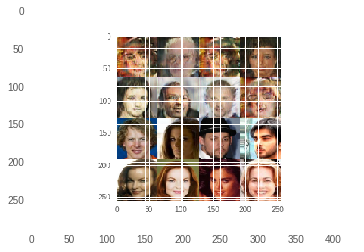


Epoch 127/400, Time: 25.336602926254272, Discriminator loss:0.83851993,Generator loss:2.1005878

Epoch 128/400, Time: 25.28951358795166, Discriminator loss:0.7780081,Generator loss:2.0398166

Epoch 129/400, Time: 25.29764223098755, Discriminator loss:0.77992785,Generator loss:2.3103747

Epoch 130/400, Time: 25.24681830406189, Discriminator loss:0.87820506,Generator loss:3.5130367

Epoch 131/400, Time: 25.26447629928589, Discriminator loss:0.8259425,Generator loss:2.568644
130


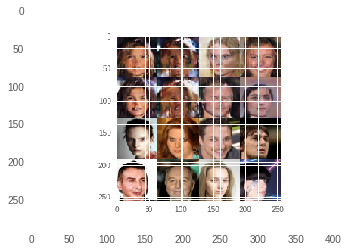


Epoch 132/400, Time: 25.269031286239624, Discriminator loss:0.78158975,Generator loss:3.030844

Epoch 133/400, Time: 25.27695608139038, Discriminator loss:0.8195033,Generator loss:2.8507133

Epoch 134/400, Time: 25.248157024383545, Discriminator loss:0.8701787,Generator loss:2.732779

Epoch 135/400, Time: 25.2575204372406, Discriminator loss:0.8234818,Generator loss:2.948314

Epoch 136/400, Time: 25.235305309295654, Discriminator loss:1.0985341,Generator loss:1.949127
135


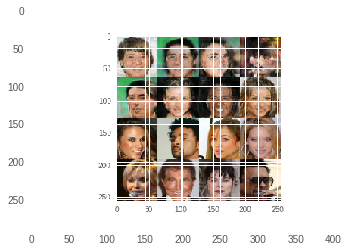


Epoch 137/400, Time: 25.33274555206299, Discriminator loss:0.81357145,Generator loss:3.1291947

Epoch 138/400, Time: 25.260523080825806, Discriminator loss:0.755393,Generator loss:4.1125536

Epoch 139/400, Time: 25.28779649734497, Discriminator loss:0.78324676,Generator loss:3.0917473

Epoch 140/400, Time: 25.286547422409058, Discriminator loss:0.80218196,Generator loss:3.64642

Epoch 141/400, Time: 25.27376675605774, Discriminator loss:0.7836871,Generator loss:3.445199
140


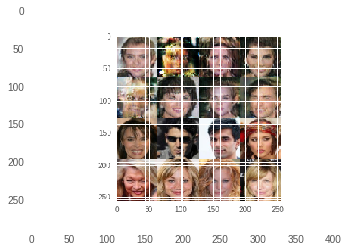


Epoch 142/400, Time: 25.31039571762085, Discriminator loss:0.7756866,Generator loss:2.482665

Epoch 143/400, Time: 25.28338313102722, Discriminator loss:0.88746554,Generator loss:2.7547214

Epoch 144/400, Time: 25.27282476425171, Discriminator loss:0.894912,Generator loss:2.9237595

Epoch 145/400, Time: 25.30895972251892, Discriminator loss:0.76656425,Generator loss:3.2872324

Epoch 146/400, Time: 25.283986806869507, Discriminator loss:0.9460478,Generator loss:2.75313
145


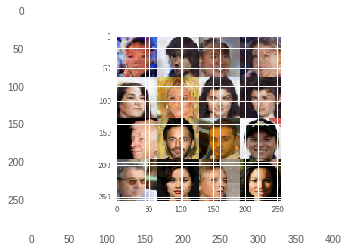


Epoch 147/400, Time: 25.291012048721313, Discriminator loss:0.80061185,Generator loss:3.1895924

Epoch 148/400, Time: 25.268908977508545, Discriminator loss:0.78774554,Generator loss:3.359476

Epoch 149/400, Time: 25.29072904586792, Discriminator loss:0.762841,Generator loss:2.802074

Epoch 150/400, Time: 25.32495903968811, Discriminator loss:0.79709643,Generator loss:2.7637799

Epoch 151/400, Time: 25.278393983840942, Discriminator loss:0.79903233,Generator loss:2.915225
150


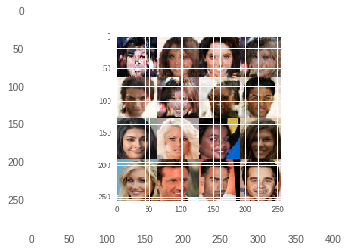


Epoch 152/400, Time: 25.341933250427246, Discriminator loss:0.7785302,Generator loss:3.296916

Epoch 153/400, Time: 25.30825424194336, Discriminator loss:0.7769346,Generator loss:3.5258281

Epoch 154/400, Time: 25.294597387313843, Discriminator loss:0.7688292,Generator loss:2.5346859

Epoch 155/400, Time: 25.271403551101685, Discriminator loss:0.80024755,Generator loss:3.3686695

Epoch 156/400, Time: 25.297219276428223, Discriminator loss:0.7999476,Generator loss:3.6929111
155


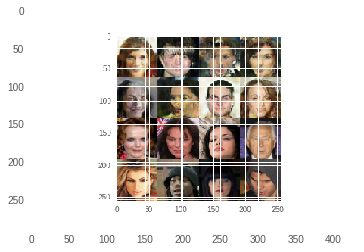


Epoch 157/400, Time: 25.27270483970642, Discriminator loss:0.9725972,Generator loss:2.3312073

Epoch 158/400, Time: 25.272563457489014, Discriminator loss:0.84639436,Generator loss:2.5447412

Epoch 159/400, Time: 25.3050856590271, Discriminator loss:0.7654058,Generator loss:2.7983985

Epoch 160/400, Time: 25.264187812805176, Discriminator loss:0.7786709,Generator loss:2.7822974

Epoch 161/400, Time: 25.295550107955933, Discriminator loss:0.77924347,Generator loss:3.3751357
160


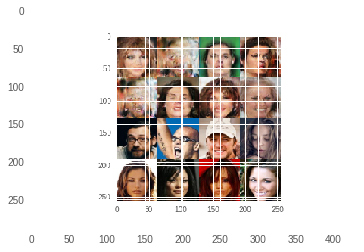


Epoch 162/400, Time: 25.28117847442627, Discriminator loss:0.80502963,Generator loss:3.4613237

Epoch 163/400, Time: 25.270832061767578, Discriminator loss:0.7689508,Generator loss:3.2630148

Epoch 164/400, Time: 25.265376806259155, Discriminator loss:0.80007267,Generator loss:2.3401098

Epoch 165/400, Time: 25.27744698524475, Discriminator loss:0.8078635,Generator loss:3.6375585

Epoch 166/400, Time: 25.281678676605225, Discriminator loss:0.82752025,Generator loss:2.9626112
165


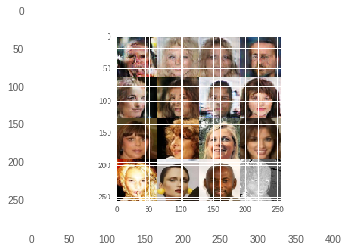


Epoch 167/400, Time: 25.267425537109375, Discriminator loss:0.7686062,Generator loss:2.919774

Epoch 168/400, Time: 25.355725526809692, Discriminator loss:0.7963319,Generator loss:3.4236336

Epoch 169/400, Time: 25.293766260147095, Discriminator loss:0.78672934,Generator loss:2.7762685

Epoch 170/400, Time: 25.2941837310791, Discriminator loss:0.75493085,Generator loss:3.442066

Epoch 171/400, Time: 25.314401388168335, Discriminator loss:0.8130621,Generator loss:3.4272308
170


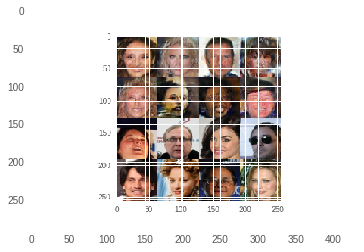


Epoch 172/400, Time: 25.32041573524475, Discriminator loss:0.7659556,Generator loss:3.1608753

Epoch 173/400, Time: 25.276578426361084, Discriminator loss:0.77817625,Generator loss:2.6309977

Epoch 174/400, Time: 25.29428720474243, Discriminator loss:0.7805874,Generator loss:3.115769

Epoch 175/400, Time: 25.331198692321777, Discriminator loss:0.7551919,Generator loss:3.0397048

Epoch 176/400, Time: 25.31596851348877, Discriminator loss:0.8141332,Generator loss:2.96752
175


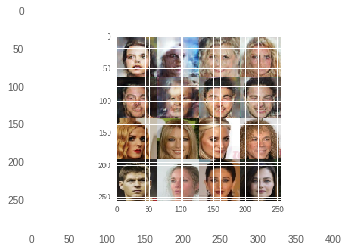


Epoch 177/400, Time: 25.275471925735474, Discriminator loss:0.7638567,Generator loss:3.4384456

Epoch 178/400, Time: 25.282230615615845, Discriminator loss:0.7637854,Generator loss:2.6123595

Epoch 179/400, Time: 25.274362325668335, Discriminator loss:0.7791474,Generator loss:3.3686438

Epoch 180/400, Time: 25.31037998199463, Discriminator loss:0.7598524,Generator loss:3.1309214

Epoch 181/400, Time: 25.28041648864746, Discriminator loss:0.8355246,Generator loss:3.3724108
180


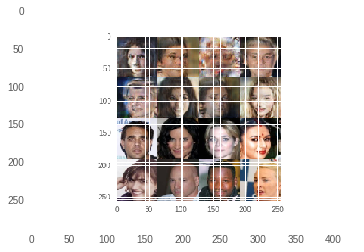


Epoch 182/400, Time: 25.29447889328003, Discriminator loss:0.772551,Generator loss:3.613193

Epoch 183/400, Time: 25.25529432296753, Discriminator loss:0.9074994,Generator loss:3.2080681

Epoch 184/400, Time: 25.299553394317627, Discriminator loss:0.7930099,Generator loss:2.8802357

Epoch 185/400, Time: 25.324084281921387, Discriminator loss:0.80909073,Generator loss:2.9516268

Epoch 186/400, Time: 25.29442024230957, Discriminator loss:0.7761249,Generator loss:2.8604355
185


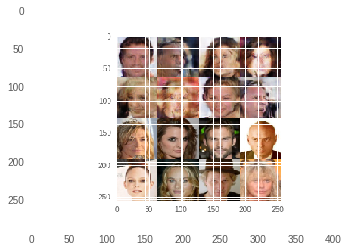


Epoch 187/400, Time: 25.30909252166748, Discriminator loss:0.8166008,Generator loss:3.4969769

Epoch 188/400, Time: 25.32233452796936, Discriminator loss:0.7792437,Generator loss:3.1454897

Epoch 189/400, Time: 25.302053689956665, Discriminator loss:0.9785718,Generator loss:2.7821896

Epoch 190/400, Time: 25.23867177963257, Discriminator loss:0.79908836,Generator loss:2.52423

Epoch 191/400, Time: 25.305098056793213, Discriminator loss:0.833967,Generator loss:2.5014782
190


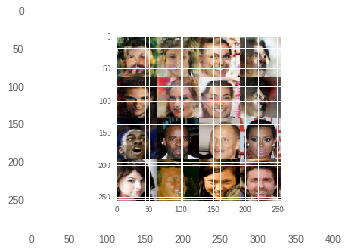


Epoch 192/400, Time: 25.443453788757324, Discriminator loss:0.75411934,Generator loss:3.090075

Epoch 193/400, Time: 25.379242181777954, Discriminator loss:0.7989913,Generator loss:2.9496167

Epoch 194/400, Time: 25.357706785202026, Discriminator loss:0.77314234,Generator loss:3.8679156

Epoch 195/400, Time: 25.307149648666382, Discriminator loss:0.8231223,Generator loss:2.709825

Epoch 196/400, Time: 25.259217739105225, Discriminator loss:0.7749078,Generator loss:2.0095692
195


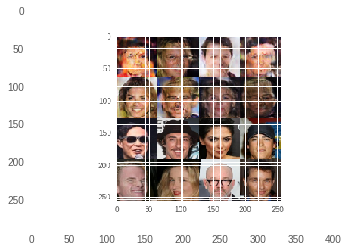


Epoch 197/400, Time: 25.29640030860901, Discriminator loss:0.7595805,Generator loss:2.905648

Epoch 198/400, Time: 25.27558445930481, Discriminator loss:0.81824875,Generator loss:2.3554325

Epoch 199/400, Time: 25.286805868148804, Discriminator loss:0.7804061,Generator loss:3.023803

Epoch 200/400, Time: 25.284035205841064, Discriminator loss:0.7912542,Generator loss:3.287733

Epoch 201/400, Time: 25.27194881439209, Discriminator loss:0.7412736,Generator loss:2.493847
200


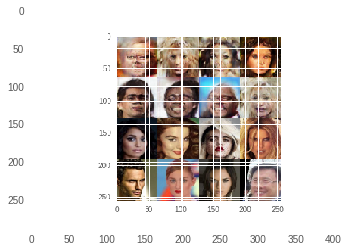


Epoch 202/400, Time: 25.2837176322937, Discriminator loss:0.86976904,Generator loss:3.406648

Epoch 203/400, Time: 25.315780639648438, Discriminator loss:0.7760685,Generator loss:3.1642995

Epoch 204/400, Time: 25.29304838180542, Discriminator loss:0.7642269,Generator loss:3.5093665

Epoch 205/400, Time: 25.27333903312683, Discriminator loss:0.7666758,Generator loss:3.0120244

Epoch 206/400, Time: 25.294738054275513, Discriminator loss:0.7777158,Generator loss:3.0563684
205


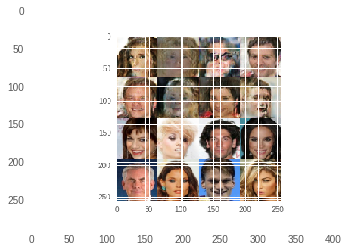


Epoch 207/400, Time: 25.26648259162903, Discriminator loss:0.8037659,Generator loss:2.8328881

Epoch 208/400, Time: 25.2771897315979, Discriminator loss:0.8254044,Generator loss:3.2115755

Epoch 209/400, Time: 25.322518348693848, Discriminator loss:0.7558235,Generator loss:3.7433796

Epoch 210/400, Time: 25.268883228302002, Discriminator loss:0.9360298,Generator loss:2.97333

Epoch 211/400, Time: 25.28817367553711, Discriminator loss:0.7750183,Generator loss:2.7046573
210


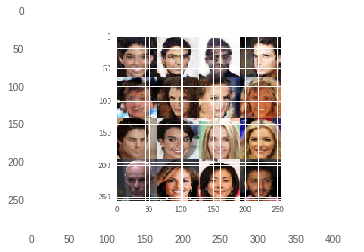


Epoch 212/400, Time: 25.29694437980652, Discriminator loss:0.87191486,Generator loss:3.0307503

Epoch 213/400, Time: 25.311429023742676, Discriminator loss:0.84752274,Generator loss:2.62573

Epoch 214/400, Time: 25.246655225753784, Discriminator loss:0.7711108,Generator loss:3.0679169

Epoch 215/400, Time: 25.268542766571045, Discriminator loss:0.7747119,Generator loss:3.0997205

Epoch 216/400, Time: 25.29410195350647, Discriminator loss:0.8142367,Generator loss:4.0131283
215


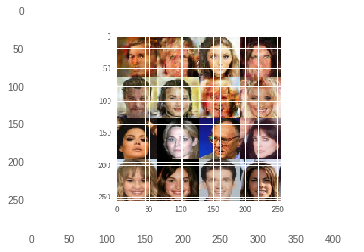


Epoch 217/400, Time: 25.303722381591797, Discriminator loss:0.83067465,Generator loss:4.0869904

Epoch 218/400, Time: 25.284053325653076, Discriminator loss:0.78598845,Generator loss:3.7290616

Epoch 219/400, Time: 25.26708483695984, Discriminator loss:0.8231623,Generator loss:2.534328

Epoch 220/400, Time: 25.255356550216675, Discriminator loss:0.7776892,Generator loss:3.0122583

Epoch 221/400, Time: 25.261730670928955, Discriminator loss:0.8891158,Generator loss:2.7086248
220


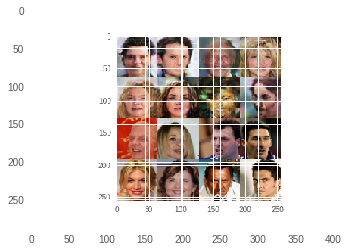


Epoch 222/400, Time: 25.262088775634766, Discriminator loss:0.76326644,Generator loss:2.7772994

Epoch 223/400, Time: 25.28378987312317, Discriminator loss:0.7619709,Generator loss:3.3934898

Epoch 224/400, Time: 25.277114868164062, Discriminator loss:0.7957828,Generator loss:3.56525

Epoch 225/400, Time: 25.280166625976562, Discriminator loss:0.7970954,Generator loss:2.4369936

Epoch 226/400, Time: 25.24946355819702, Discriminator loss:0.81576467,Generator loss:3.3647633
225


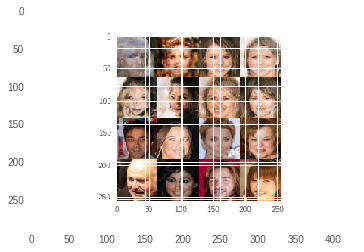


Epoch 227/400, Time: 25.29866933822632, Discriminator loss:0.84000933,Generator loss:3.765647

Epoch 228/400, Time: 25.302551746368408, Discriminator loss:0.77312523,Generator loss:2.612949

Epoch 229/400, Time: 25.277110815048218, Discriminator loss:0.77000916,Generator loss:2.2600853

Epoch 230/400, Time: 25.28731369972229, Discriminator loss:0.93407094,Generator loss:3.141639

Epoch 231/400, Time: 25.301600694656372, Discriminator loss:0.9108871,Generator loss:2.5461829
230


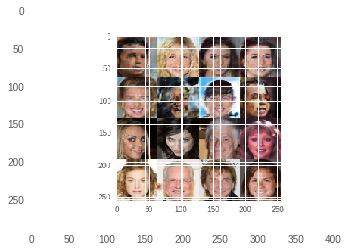


Epoch 232/400, Time: 25.309619188308716, Discriminator loss:0.7573117,Generator loss:2.7803385

Epoch 233/400, Time: 25.265962839126587, Discriminator loss:0.7818527,Generator loss:3.4411407

Epoch 234/400, Time: 25.28002142906189, Discriminator loss:0.7682625,Generator loss:3.4330828

Epoch 235/400, Time: 25.273135662078857, Discriminator loss:0.7472795,Generator loss:3.0340817

Epoch 236/400, Time: 25.270251274108887, Discriminator loss:0.8294689,Generator loss:3.3496912
235


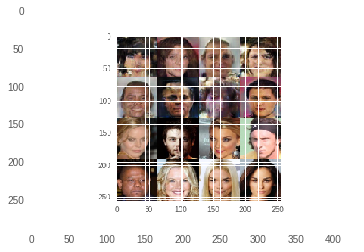


Epoch 237/400, Time: 25.31284523010254, Discriminator loss:0.8107456,Generator loss:3.1661634

Epoch 238/400, Time: 25.252577781677246, Discriminator loss:0.7719295,Generator loss:3.6326332

Epoch 239/400, Time: 25.27591562271118, Discriminator loss:0.7298062,Generator loss:2.7584114

Epoch 240/400, Time: 25.268917083740234, Discriminator loss:0.95185375,Generator loss:2.7201574

Epoch 241/400, Time: 25.286335468292236, Discriminator loss:0.796412,Generator loss:3.1213531
240


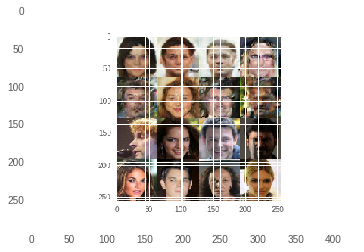


Epoch 242/400, Time: 25.312140703201294, Discriminator loss:0.8147268,Generator loss:4.2265577

Epoch 243/400, Time: 25.264714241027832, Discriminator loss:0.8150937,Generator loss:3.1644316

Epoch 244/400, Time: 25.287418603897095, Discriminator loss:0.7376831,Generator loss:3.2709374

Epoch 245/400, Time: 25.25493574142456, Discriminator loss:0.76778316,Generator loss:3.0444562

Epoch 246/400, Time: 25.280075311660767, Discriminator loss:0.76057255,Generator loss:2.463988
245


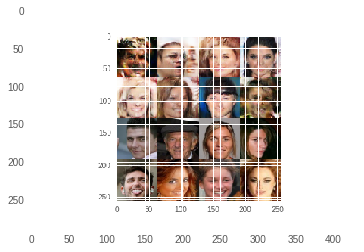


Epoch 247/400, Time: 25.31402897834778, Discriminator loss:0.73342884,Generator loss:3.2871222

Epoch 248/400, Time: 25.266170263290405, Discriminator loss:0.86234546,Generator loss:3.5554624

Epoch 249/400, Time: 25.275195121765137, Discriminator loss:0.88354284,Generator loss:3.5789733

Epoch 250/400, Time: 25.292919635772705, Discriminator loss:0.7603195,Generator loss:3.6227698

Epoch 251/400, Time: 25.319272994995117, Discriminator loss:0.8374299,Generator loss:3.3831913
250


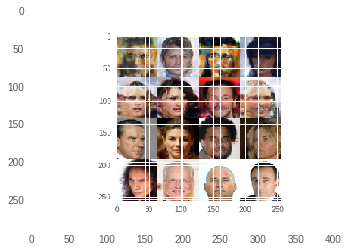


Epoch 252/400, Time: 25.311915636062622, Discriminator loss:0.7917423,Generator loss:2.7258723

Epoch 253/400, Time: 25.578559398651123, Discriminator loss:0.7995059,Generator loss:2.6566672

Epoch 254/400, Time: 25.31570839881897, Discriminator loss:0.7574318,Generator loss:3.8197403

Epoch 255/400, Time: 25.275572776794434, Discriminator loss:0.9338647,Generator loss:3.5269327

Epoch 256/400, Time: 25.317253828048706, Discriminator loss:0.80406946,Generator loss:3.100266
255


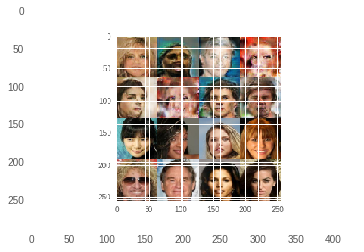


Epoch 257/400, Time: 25.309157609939575, Discriminator loss:0.75140965,Generator loss:3.5125403

Epoch 258/400, Time: 25.320966482162476, Discriminator loss:0.8333607,Generator loss:3.0946217

Epoch 259/400, Time: 25.28748345375061, Discriminator loss:0.82953876,Generator loss:4.2139406

Epoch 260/400, Time: 25.258728504180908, Discriminator loss:0.7574134,Generator loss:3.018581

Epoch 261/400, Time: 25.276310920715332, Discriminator loss:0.78923774,Generator loss:3.6184504
260


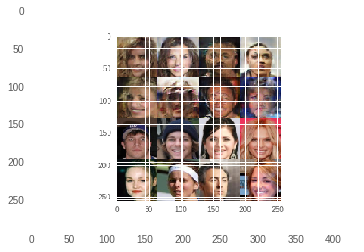


Epoch 262/400, Time: 25.341809272766113, Discriminator loss:0.7781081,Generator loss:3.1150177

Epoch 263/400, Time: 25.25797390937805, Discriminator loss:0.7399539,Generator loss:3.1035228

Epoch 264/400, Time: 25.27996587753296, Discriminator loss:0.81899816,Generator loss:2.8944159

Epoch 265/400, Time: 25.300482511520386, Discriminator loss:0.80476725,Generator loss:2.8580847

Epoch 266/400, Time: 25.331190586090088, Discriminator loss:0.75874025,Generator loss:3.406458
265


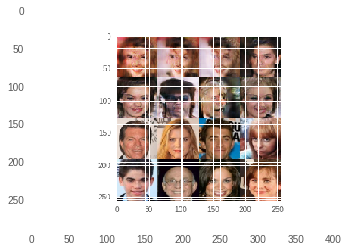


Epoch 267/400, Time: 25.293752670288086, Discriminator loss:0.803457,Generator loss:2.7508733

Epoch 268/400, Time: 25.29288363456726, Discriminator loss:0.76459086,Generator loss:2.8558502

Epoch 269/400, Time: 25.3781681060791, Discriminator loss:0.8060033,Generator loss:3.842371

Epoch 270/400, Time: 25.330825567245483, Discriminator loss:0.7902904,Generator loss:2.3888383

Epoch 271/400, Time: 25.285970449447632, Discriminator loss:0.7942195,Generator loss:3.7957668
270


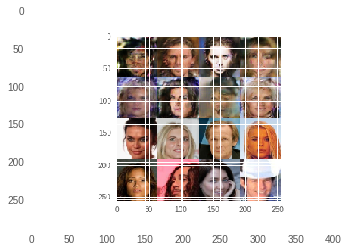


Epoch 272/400, Time: 25.272015810012817, Discriminator loss:0.7307793,Generator loss:3.4747105

Epoch 273/400, Time: 25.25945806503296, Discriminator loss:0.7913946,Generator loss:3.8379774

Epoch 274/400, Time: 25.24632716178894, Discriminator loss:0.7497567,Generator loss:3.7357054

Epoch 275/400, Time: 25.259272813796997, Discriminator loss:0.7987757,Generator loss:2.6273913

Epoch 276/400, Time: 25.24927568435669, Discriminator loss:0.7973839,Generator loss:2.8314576
275


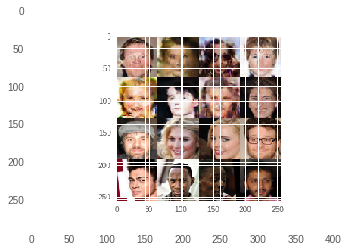


Epoch 277/400, Time: 25.32537841796875, Discriminator loss:0.7862543,Generator loss:3.428368

Epoch 278/400, Time: 25.293346881866455, Discriminator loss:0.84493476,Generator loss:3.4984403

Epoch 279/400, Time: 25.313803672790527, Discriminator loss:0.75491333,Generator loss:3.221779

Epoch 280/400, Time: 25.28258776664734, Discriminator loss:0.74715424,Generator loss:3.6921601

Epoch 281/400, Time: 25.265305042266846, Discriminator loss:0.82171273,Generator loss:4.0873685
280


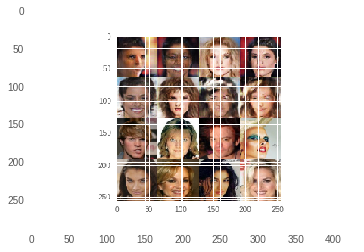


Epoch 282/400, Time: 25.268574714660645, Discriminator loss:0.818709,Generator loss:3.2395186

Epoch 283/400, Time: 25.283936738967896, Discriminator loss:0.86546755,Generator loss:2.9646451

Epoch 284/400, Time: 25.284214973449707, Discriminator loss:0.77026176,Generator loss:3.8435555

Epoch 285/400, Time: 25.304193019866943, Discriminator loss:0.80393267,Generator loss:2.499041

Epoch 286/400, Time: 25.254314422607422, Discriminator loss:0.76479506,Generator loss:3.3205705
285


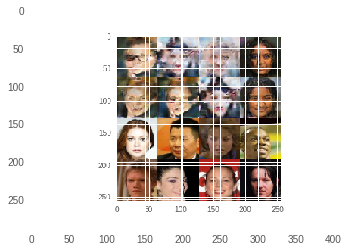


Epoch 287/400, Time: 25.256852865219116, Discriminator loss:0.8302901,Generator loss:3.091042

Epoch 288/400, Time: 25.28797435760498, Discriminator loss:0.78637695,Generator loss:3.958554

Epoch 289/400, Time: 25.243430376052856, Discriminator loss:0.9355489,Generator loss:3.2109015

Epoch 290/400, Time: 25.265355587005615, Discriminator loss:0.8046231,Generator loss:3.3038902

Epoch 291/400, Time: 25.264020204544067, Discriminator loss:0.78655916,Generator loss:3.626431
290


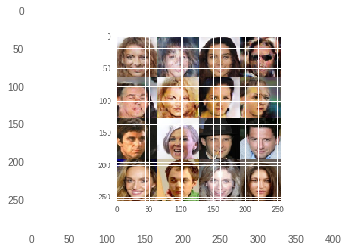


Epoch 292/400, Time: 25.257728338241577, Discriminator loss:0.76885545,Generator loss:3.8278058

Epoch 293/400, Time: 25.255894899368286, Discriminator loss:0.7740135,Generator loss:3.0964744

Epoch 294/400, Time: 25.235758781433105, Discriminator loss:0.7552252,Generator loss:3.5057936

Epoch 295/400, Time: 25.232386827468872, Discriminator loss:0.74794626,Generator loss:2.887663

Epoch 296/400, Time: 25.283266305923462, Discriminator loss:0.7744001,Generator loss:3.537807
295


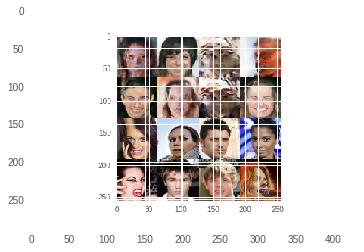


Epoch 297/400, Time: 25.260409832000732, Discriminator loss:0.89274406,Generator loss:3.1858883

Epoch 298/400, Time: 25.249725580215454, Discriminator loss:0.7728262,Generator loss:3.2128706

Epoch 299/400, Time: 25.222506046295166, Discriminator loss:0.74185425,Generator loss:4.041852

Epoch 300/400, Time: 25.23439359664917, Discriminator loss:0.76196235,Generator loss:3.2624152

Epoch 301/400, Time: 25.23190426826477, Discriminator loss:0.73192513,Generator loss:3.3211708
300


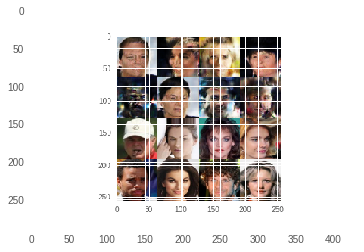


Epoch 302/400, Time: 25.261780738830566, Discriminator loss:0.86479247,Generator loss:3.1898797

Epoch 303/400, Time: 25.268798828125, Discriminator loss:0.7557829,Generator loss:3.521908

Epoch 304/400, Time: 25.281991004943848, Discriminator loss:0.81721354,Generator loss:4.4807386

Epoch 305/400, Time: 25.252058744430542, Discriminator loss:0.7548658,Generator loss:2.9589334

Epoch 306/400, Time: 25.23697018623352, Discriminator loss:0.8210923,Generator loss:3.1784875
305


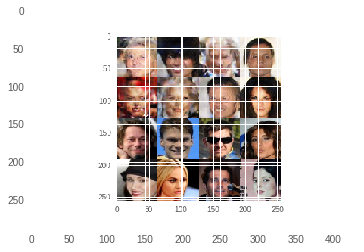


Epoch 307/400, Time: 25.212301015853882, Discriminator loss:0.78500676,Generator loss:3.4025583

Epoch 308/400, Time: 25.221916675567627, Discriminator loss:0.75558424,Generator loss:3.0115032

Epoch 309/400, Time: 25.223400354385376, Discriminator loss:0.83498883,Generator loss:4.1034436

Epoch 310/400, Time: 25.25553274154663, Discriminator loss:0.7335218,Generator loss:3.0729299

Epoch 311/400, Time: 25.175560474395752, Discriminator loss:0.78977644,Generator loss:3.2783985
310


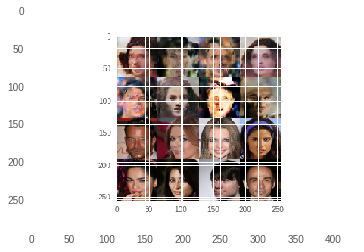


Epoch 312/400, Time: 25.095017671585083, Discriminator loss:0.818578,Generator loss:2.5141087

Epoch 313/400, Time: 25.11996030807495, Discriminator loss:0.7586781,Generator loss:2.6674418

Epoch 314/400, Time: 25.124658346176147, Discriminator loss:0.7775521,Generator loss:3.1230485

Epoch 315/400, Time: 25.116309881210327, Discriminator loss:0.7729387,Generator loss:3.3740103

Epoch 316/400, Time: 25.12539529800415, Discriminator loss:0.7426805,Generator loss:3.8624392
315


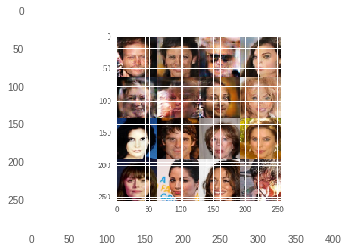


Epoch 317/400, Time: 25.113123655319214, Discriminator loss:0.7428822,Generator loss:3.8358066

Epoch 318/400, Time: 25.10715103149414, Discriminator loss:0.7610946,Generator loss:3.9306946

Epoch 319/400, Time: 25.12183666229248, Discriminator loss:0.77006125,Generator loss:4.2338176

Epoch 320/400, Time: 25.151036977767944, Discriminator loss:0.8174288,Generator loss:3.2584867

Epoch 321/400, Time: 25.113767623901367, Discriminator loss:0.7437306,Generator loss:4.0426035
320


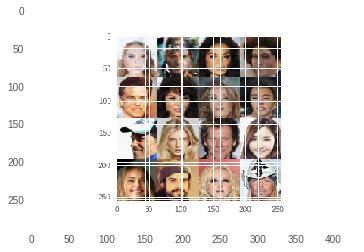


Epoch 322/400, Time: 25.159706354141235, Discriminator loss:0.75023973,Generator loss:2.978477

Epoch 323/400, Time: 25.15266513824463, Discriminator loss:0.7564362,Generator loss:3.3434753

Epoch 324/400, Time: 25.165873289108276, Discriminator loss:0.8189039,Generator loss:3.1494215

Epoch 325/400, Time: 25.086461782455444, Discriminator loss:0.7917092,Generator loss:3.501484

Epoch 326/400, Time: 25.08492612838745, Discriminator loss:0.75252974,Generator loss:3.4618073
325


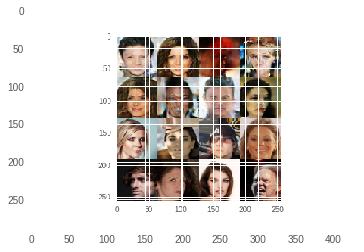


Epoch 327/400, Time: 25.134387731552124, Discriminator loss:0.7892528,Generator loss:3.7837138

Epoch 328/400, Time: 25.14549446105957, Discriminator loss:0.72681355,Generator loss:2.7691102

Epoch 329/400, Time: 25.160412073135376, Discriminator loss:0.77198637,Generator loss:3.2510066

Epoch 330/400, Time: 25.146857023239136, Discriminator loss:0.79125166,Generator loss:3.6483102

Epoch 331/400, Time: 25.155391454696655, Discriminator loss:0.7574216,Generator loss:2.8710456
330


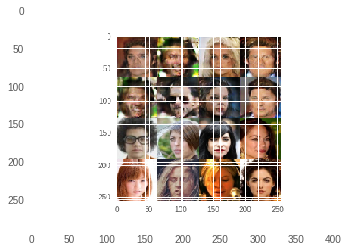


Epoch 332/400, Time: 25.16538405418396, Discriminator loss:0.84885794,Generator loss:3.529935

Epoch 333/400, Time: 25.113890409469604, Discriminator loss:0.7650033,Generator loss:2.9424644

Epoch 334/400, Time: 25.123790979385376, Discriminator loss:0.7634598,Generator loss:3.1433587

Epoch 335/400, Time: 25.174617767333984, Discriminator loss:0.77881813,Generator loss:3.7850718

Epoch 336/400, Time: 25.21663188934326, Discriminator loss:0.7746737,Generator loss:3.0414426
335


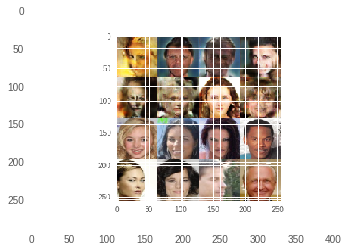


Epoch 337/400, Time: 25.24317216873169, Discriminator loss:0.79459596,Generator loss:4.440912

Epoch 338/400, Time: 25.239928245544434, Discriminator loss:0.76799583,Generator loss:4.1363034

Epoch 339/400, Time: 25.21747350692749, Discriminator loss:0.77466106,Generator loss:2.8078356

Epoch 340/400, Time: 25.247541666030884, Discriminator loss:0.8171957,Generator loss:3.3495028

Epoch 341/400, Time: 25.247012615203857, Discriminator loss:0.7698444,Generator loss:2.5654726
340


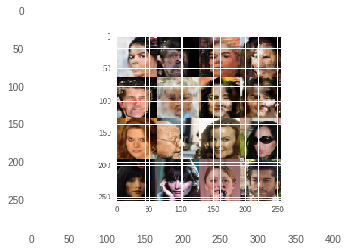


Epoch 342/400, Time: 25.252387523651123, Discriminator loss:0.80419225,Generator loss:3.251346

Epoch 343/400, Time: 25.236709594726562, Discriminator loss:0.7717097,Generator loss:2.8521242

Epoch 344/400, Time: 25.242121696472168, Discriminator loss:0.73703396,Generator loss:6.315981

Epoch 345/400, Time: 25.22601866722107, Discriminator loss:0.80425006,Generator loss:3.5633605

Epoch 346/400, Time: 25.225918292999268, Discriminator loss:0.87994283,Generator loss:3.4589746
345


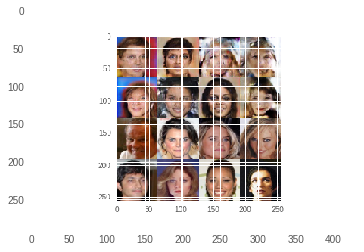


Epoch 347/400, Time: 25.24782395362854, Discriminator loss:0.8444834,Generator loss:3.3377256

Epoch 348/400, Time: 25.241214275360107, Discriminator loss:0.8076619,Generator loss:4.358529

Epoch 349/400, Time: 25.238696098327637, Discriminator loss:0.79262316,Generator loss:3.3793166

Epoch 350/400, Time: 25.221054077148438, Discriminator loss:0.7800371,Generator loss:3.529416

Epoch 351/400, Time: 25.190961837768555, Discriminator loss:0.7798492,Generator loss:3.0122914
350


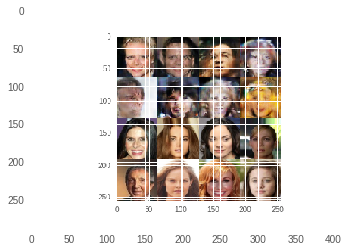


Epoch 352/400, Time: 25.176230430603027, Discriminator loss:0.76381505,Generator loss:3.4276125

Epoch 353/400, Time: 25.203861474990845, Discriminator loss:0.7449637,Generator loss:4.8326516

Epoch 354/400, Time: 25.18091344833374, Discriminator loss:0.7498487,Generator loss:3.9498434

Epoch 355/400, Time: 25.20409107208252, Discriminator loss:0.8022609,Generator loss:2.7576869

Epoch 356/400, Time: 25.219223260879517, Discriminator loss:0.77747095,Generator loss:2.6874456
355


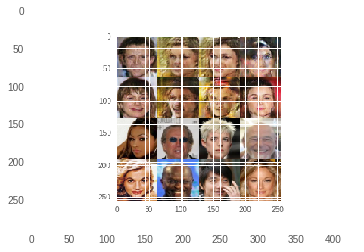


Epoch 357/400, Time: 25.206948280334473, Discriminator loss:0.818243,Generator loss:3.6398516

Epoch 358/400, Time: 25.198254823684692, Discriminator loss:0.79200613,Generator loss:3.3372006

Epoch 359/400, Time: 25.19658899307251, Discriminator loss:0.7915231,Generator loss:2.8074944

Epoch 360/400, Time: 25.196773052215576, Discriminator loss:0.7546209,Generator loss:3.7061052

Epoch 361/400, Time: 25.20648694038391, Discriminator loss:0.84519583,Generator loss:3.0873423
360


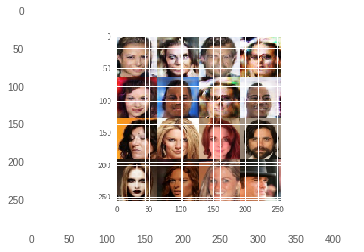


Epoch 362/400, Time: 25.21449112892151, Discriminator loss:0.7532432,Generator loss:3.035994

Epoch 363/400, Time: 25.204901456832886, Discriminator loss:0.79183424,Generator loss:3.964189

Epoch 364/400, Time: 25.21018099784851, Discriminator loss:0.7643831,Generator loss:4.168145

Epoch 365/400, Time: 25.209751844406128, Discriminator loss:0.76381135,Generator loss:3.5392048

Epoch 366/400, Time: 25.21935248374939, Discriminator loss:0.82426167,Generator loss:3.338821
365


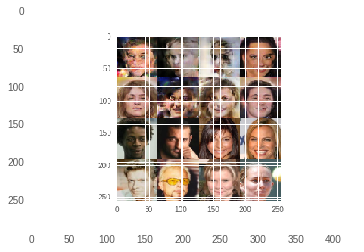


Epoch 367/400, Time: 25.182053089141846, Discriminator loss:0.76061934,Generator loss:3.4447608

Epoch 368/400, Time: 25.21017050743103, Discriminator loss:0.77526975,Generator loss:4.1113257

Epoch 369/400, Time: 25.196715354919434, Discriminator loss:0.77009237,Generator loss:3.1130095

Epoch 370/400, Time: 25.214393138885498, Discriminator loss:0.8662509,Generator loss:2.8888102

Epoch 371/400, Time: 25.206608772277832, Discriminator loss:0.9054316,Generator loss:4.181486
370


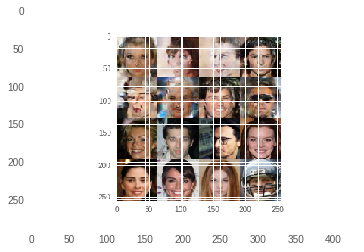


Epoch 372/400, Time: 25.243858814239502, Discriminator loss:0.8047086,Generator loss:2.6888647

Epoch 373/400, Time: 25.206023931503296, Discriminator loss:0.7479128,Generator loss:3.661223

Epoch 374/400, Time: 25.179829835891724, Discriminator loss:0.80514175,Generator loss:4.664871

Epoch 375/400, Time: 25.213620901107788, Discriminator loss:0.7761145,Generator loss:3.823268

Epoch 376/400, Time: 25.185510635375977, Discriminator loss:0.8555592,Generator loss:3.3317642
375


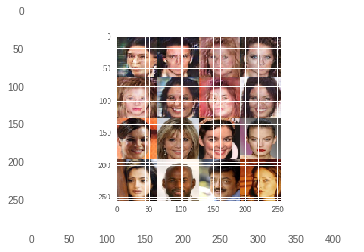


Epoch 377/400, Time: 25.223851680755615, Discriminator loss:0.7815667,Generator loss:4.084966

Epoch 378/400, Time: 25.18437123298645, Discriminator loss:0.7554009,Generator loss:3.209623

Epoch 379/400, Time: 25.169198989868164, Discriminator loss:0.888783,Generator loss:3.6878953

Epoch 380/400, Time: 25.17395782470703, Discriminator loss:0.73833567,Generator loss:4.0737686

Epoch 381/400, Time: 25.170005798339844, Discriminator loss:0.7626908,Generator loss:3.2912426
380


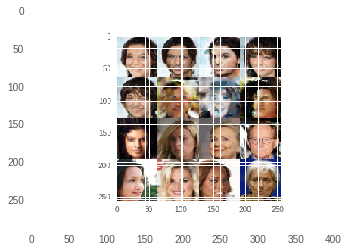


Epoch 382/400, Time: 25.209259748458862, Discriminator loss:0.85728824,Generator loss:4.863102

Epoch 383/400, Time: 25.170494079589844, Discriminator loss:0.7548353,Generator loss:3.975415

Epoch 384/400, Time: 25.201077699661255, Discriminator loss:0.8046484,Generator loss:3.5688994

Epoch 385/400, Time: 25.216855764389038, Discriminator loss:0.77416027,Generator loss:3.3738966

Epoch 386/400, Time: 25.18608784675598, Discriminator loss:0.7516244,Generator loss:3.7473607
385


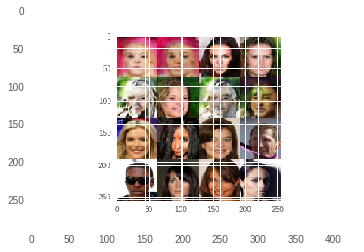


Epoch 387/400, Time: 25.196677207946777, Discriminator loss:0.7838832,Generator loss:3.3011065

Epoch 388/400, Time: 25.211802005767822, Discriminator loss:0.8501761,Generator loss:3.3806753

Epoch 389/400, Time: 25.183741807937622, Discriminator loss:0.7920879,Generator loss:3.609703

Epoch 390/400, Time: 25.170747756958008, Discriminator loss:0.7599258,Generator loss:3.3434272

Epoch 391/400, Time: 25.240000009536743, Discriminator loss:0.76483333,Generator loss:4.230012
390


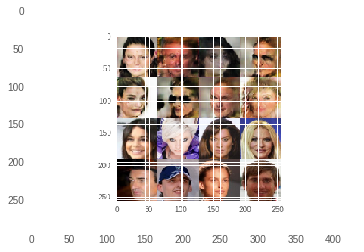


Epoch 392/400, Time: 25.240142345428467, Discriminator loss:0.77305794,Generator loss:4.1878066

Epoch 393/400, Time: 25.27400255203247, Discriminator loss:0.77019846,Generator loss:3.8197703

Epoch 394/400, Time: 25.26910161972046, Discriminator loss:0.7623747,Generator loss:2.9642816

Epoch 395/400, Time: 25.26459789276123, Discriminator loss:0.78311056,Generator loss:3.0542262

Epoch 396/400, Time: 25.282029390335083, Discriminator loss:0.7549135,Generator loss:3.662139
395


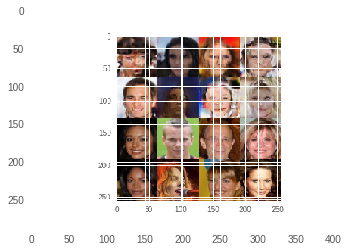


Epoch 397/400, Time: 25.327003717422485, Discriminator loss:0.76197314,Generator loss:3.6800754

Epoch 398/400, Time: 25.297372817993164, Discriminator loss:0.7578511,Generator loss:3.3795133

Epoch 399/400, Time: 25.313791513442993, Discriminator loss:0.7942938,Generator loss:4.499987

Epoch 400/400, Time: 25.3080792427063, Discriminator loss:0.7645519,Generator loss:3.5236022


In [15]:
os.environ["KERAS_BACKEND"] = "tensorflow" #Set backend to tensorflow
#image_data_format = "channels_last" #Setting image data format for tensorflow
K.set_image_data_format(image_data_format)    
# Launch training
train_GAN(batch_size,n_batch_per_epoch,nb_epoch,generator,model_name,image_data_format,img_dim,bn_mode,label_smoothing,label_flipping,noise_scale,dset,use_mbd,epoch)

# Display final generated images

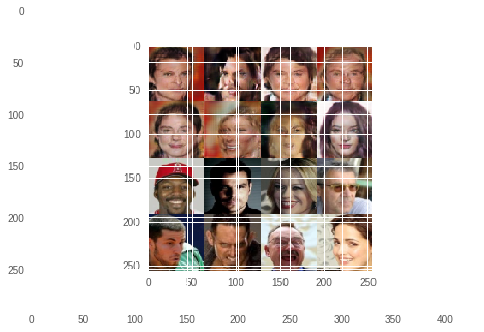

In [31]:
#Display final image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage, misc
fig=plt.figure(figsize=(8, 8))

img=mpimg.imread('./figures/current_batch.png')

imgplot = plt.imshow(img)
plt.show()


In [0]:
#import os, signal
#os.kill(os.getpid(), signal.SIGKILL)